<a href="https://colab.research.google.com/github/vvshyer/tensorflow2.0_learning/blob/master/tf_keras_regression_hp_search_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.3
pandas 0.24.2
sklearn 0.21.1
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

# test_size默认为0.25
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7, test_size = 0.25)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [6]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数
def build_model(hidden_layers = 1, 
                layer_size = 30, 
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers-1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs=100,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)
    

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 49us/sample - loss: 1.2424 - val_loss: 0.7345
Epoch 2/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6395 - val_loss: 0.6354
Epoch 3/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5614 - val_loss: 0.5708
Epoch 4/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5136 - val_loss: 0.5281
Epoch 5/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4877 - val_loss: 0.5106
Epoch 6/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4709 - val_loss: 0.4986
Epoch 7/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4579 - val_loss: 0.4740
Epoch 8/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4485 - val_loss: 0.4662
Epoch 9/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.440

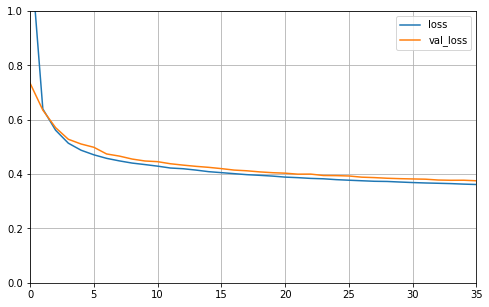

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [11]:
from scipy.stats import reciprocal
# 分布函数：f(x) = 1/(x*log(b/a)) a<=x<=b
param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate":reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, 
                                      param_distribution,
                                      n_iter = 10,
                                      n_jobs = 1)

"""
cross_validation: 训练集分成n份，n-1份训练，最后一份验证
默认cv = 3
random_search_cv = RandomizedSearchCV(sklearn_model, 
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)

"""

random_search_cv.fit(x_train_scaled, y_train,
                            epochs=100,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 53us/sample - loss: 5.0586 - val_loss: 3.5980
Epoch 2/100
7740/7740 [==============================] - 0s 39us/sample - loss: 2.5069 - val_loss: 1.9964
Epoch 3/100
7740/7740 [==============================] - 0s 38us/sample - loss: 1.5469 - val_loss: 1.4144
Epoch 4/100
7740/7740 [==============================] - 0s 38us/sample - loss: 1.2067 - val_loss: 1.2013
Epoch 5/100
7740/7740 [==============================] - 0s 37us/sample - loss: 1.0727 - val_loss: 1.0996
Epoch 6/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.0013 - val_loss: 1.0367
Epoch 7/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.9521 - val_loss: 0.9890
Epoch 8/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.9128 - val_loss: 0.9507
Epoch 9/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.8805 - val_loss: 0.919

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f2d45a26c18>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 3...46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d38b72d68>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_s

In [12]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 2, 'layer_size': 64, 'learning_rate': 0.0074971092331801445}
-0.34148263905604886


In [13]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 17us/sample - loss: 0.3413


0.3412971150043399